In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

from dataclasses import dataclass

import sys
import os
sys.path.append(os.path.abspath('../'))
from utils.parse_data import load_trained_model, parse_simulated_data, get_data_filenames, add_sequence_columns

import utils.file_management as fm

%load_ext autoreload
%autoreload 2


In [2]:
sns.set_theme(
    style='ticks',
    font_scale=1.0,
    rc={'axes.labelsize': 11,
        'axes.titlesize': 11,
        'savefig.transparent': True,
        'legend.title_fontsize': 11,
        'legend.fontsize': 10,
        'legend.borderpad': 0.2,
        'figure.titlesize': 11,
        'figure.subplot.wspace': 0.1,
        })

In [3]:
# Load the model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

run = fm.get_latest_run()
model, model_info, config = load_trained_model(run, model_name=None, device=device, weights_only=False)

Using cpu device


In [42]:
def gradient_times_input(model, sequence, stoi, target_token_idx=None, use_loss=False):
    """
    Compute gradient * input for a specific prediction with fixes for gradient tracking.
    """    
    # Convert sequence to token IDs
    token_ids = [stoi[char] for char in sequence]
    input_tensor = torch.tensor(token_ids, dtype=torch.long).unsqueeze(0).to(model.device)
    # Create target tensor that matches input sequence length
    B, T = input_tensor.size()  # B=1, T=length of sequence
    if target_token_idx is not None:
        # Create a target tensor where we only care about predicting the last position
        target_tensor = torch.full((B, T), -100, dtype=torch.long).to(model.device)  # -100 is ignored in loss
        target_tensor[:, -1] = target_token_idx  # Set target only for last position
    else:
        target_tensor = None
    # Train mode for gradient tracking
    original_mode = model.training
    model.train()
    
    # Track embeddings with a hook since retain_grad() isn't always reliable
    embedding_gradients = []
    embedding_values = []
    
    def capture_embeddings_hook(module, inp, out):
        out.requires_grad_(True)
        embedding_values.append(out.detach().clone())
        
        # Define a hook for backward
        def capture_grads_hook(grad):
            embedding_gradients.append(grad.detach().clone())
            return grad
            
        out.register_hook(capture_grads_hook)
        return out
    
    # Register the hook on the embedding layer
    embedding_hook = model.transformer.wte.register_forward_hook(capture_embeddings_hook)
    
    # Forward pass
    logits, loss = model(input_tensor, targets=target_tensor)
    
    # Backward pass based on target
    if not use_loss:
        # Target for a specific prediction
        target = torch.zeros_like(logits)
        target[0, -1, target_token_idx] = 1.0  # Focus on last token prediction
        logits.backward(target)
    else:
        # Use the model's loss

        loss.backward()
    
    # Remove hook
    embedding_hook.remove()
    
    # Restore original mode
    model.train(original_mode)
    
    # Check if we captured gradients
    if not embedding_gradients:
        print("WARNING: No gradients were captured! Check model architecture.")
        return None
    
    # Compute gradient * input
    embeddings = embedding_values[0]
    embedding_grad = embedding_gradients[0]
    
    # Element-wise multiplication and sum along embedding dimension
    attribution = (embeddings * embedding_grad).sum(dim=-1)
    
    return attribution.cpu().numpy()


In [5]:
vocab = ['R', 'r', 'L', 'l']
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for i, ch in enumerate(vocab)}
T = model_info['dataloader']['Sequence length (T)']

events = parse_simulated_data(*get_data_filenames(run, suffix='v'))
events = add_sequence_columns(events, T)
vc = events[f'seq{T}_RL'].value_counts()
sequences = vc[vc > 100].sample(n=20).index

In [45]:
sequences = ['RRRRRR',
             'RRRRRr',
             'RRRRrR']

Analyzing sequence: RRRRrR


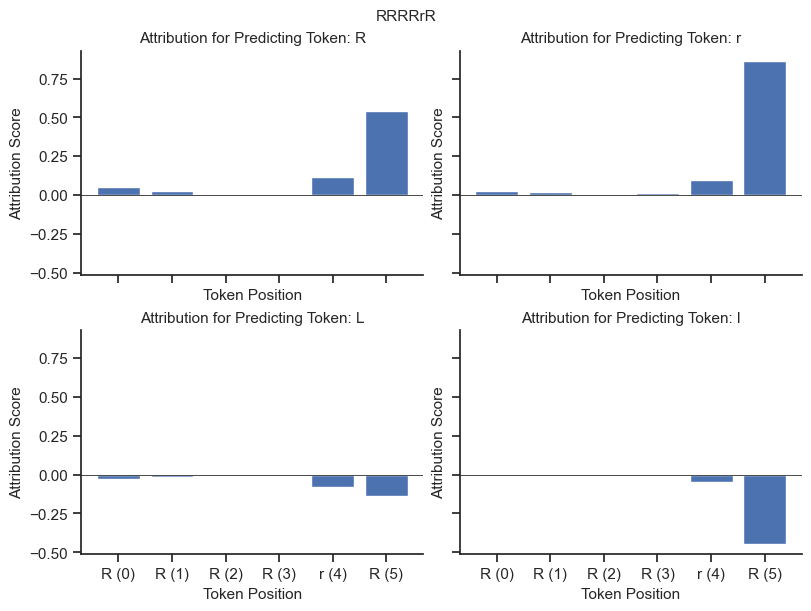

In [72]:
sequence = sequences[2]

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), layout='constrained', sharex=True, sharey=True)
print(f"Analyzing sequence: {sequence}")

for t, ax in zip(vocab, axs.flatten()):
    # Analyze attribution for predicting a specific token as the next token
    target_idx = stoi[t]  # Change to whatever token you're interested in
    attribution = gradient_times_input(model, sequence, stoi, target_idx, use_loss=False)
    ax.bar(range(len(sequence)), attribution[0])
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_xticks(range(len(sequence)), [f"{c} ({i})" for i, c in enumerate(sequence)])
    ax.set(title=f"Attribution for Predicting Token: {list(stoi.keys())[target_idx]}",
        xlabel="Token Position",
        ylabel="Attribution Score")
    
fig.suptitle(sequence)
sns.despine()

Analyzing sequence: RRRRRR
Analyzing sequence: RRRRRr
Analyzing sequence: RRRRrR
Analyzing sequence: RRRrRR
Analyzing sequence: RRRRRl


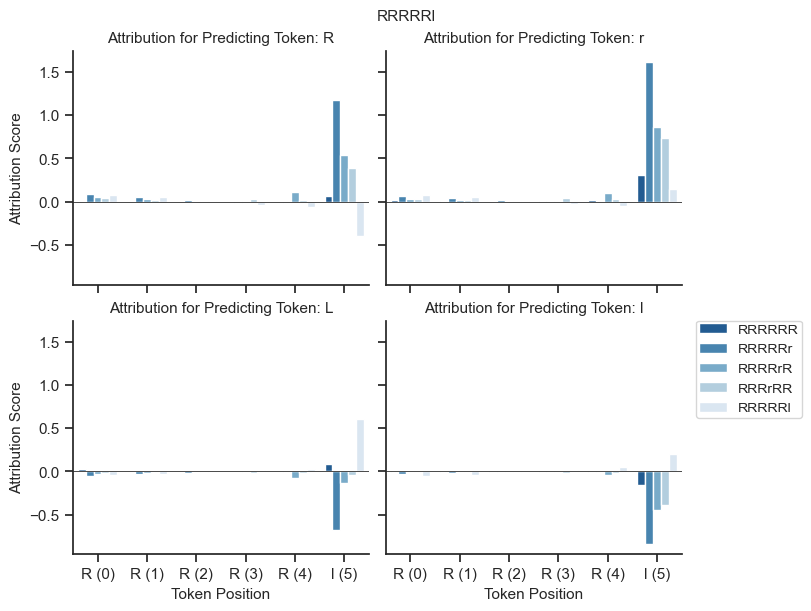

In [87]:
sequences = ['RRRRRR',
             'RRRRRr',
             'RRRRrR',
             'RRRrRR',
             'RRRRRl']

attributions = []

for sequence in sequences:
    print(f"Analyzing sequence: {sequence}")

    for t in vocab:
        # Analyze attribution for predicting a specific token as the next token
        target_idx = stoi[t]  # Change to whatever token you're interested in
        attribution = gradient_times_input(model, sequence, stoi, target_idx, use_loss=False)
        attributions.append(pd.DataFrame({'pos': range(len(sequence)), 'token': list(sequence),
                                          'attribution': attribution.squeeze(), 'sequence': sequence, 'target_token': t}))

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), layout='constrained', sharex=True, sharey=True)

attributions = pd.concat(attributions)

for t, ax in zip(vocab, axs.flatten()):
    sns.barplot(data=attributions.query('target_token == @t'), x='pos', y='attribution', hue='sequence', ax=ax, palette='Blues_r', legend=t==vocab[-1])
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_xticks(range(len(sequence)), [f"{c} ({i})" for i, c in enumerate(sequence)])
    ax.set(title=f"Attribution for Predicting Token: {t}",
        xlabel="Token Position",
        ylabel="Attribution Score")
fig.suptitle(sequence)
sns.despine()

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

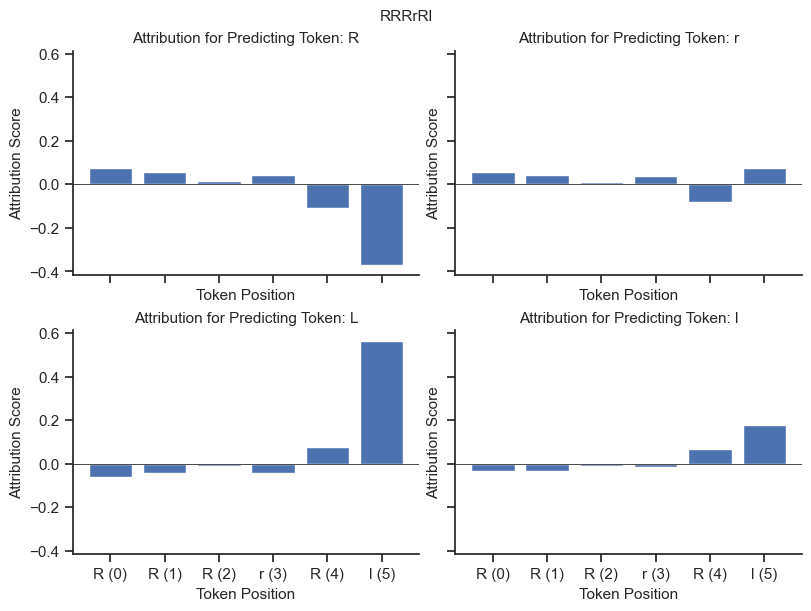

In [44]:

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), layout='constrained', sharex=True, sharey=True)

for t, ax in zip(vocab, axs.flatten()):
    # Analyze attribution for predicting a specific token as the next token
    target_idx = stoi[t]  # Change to whatever token you're interested in
    attribution = gradient_times_input(model, sequence, stoi, target_idx, use_loss=False)
    ax.bar(range(len(sequence)), attribution[0])
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_xticks(range(len(sequence)), [f"{c} ({i})" for i, c in enumerate(sequence)])
    ax.set(title=f"Attribution for Predicting Token: {list(stoi.keys())[target_idx]}",
           xlabel="Token Position",
           ylabel="Attribution Score")
    
fig.suptitle(sequence)
sns.despine()